In [1]:
#import os pacotes utilizados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()
%matplotlib inline

#selecionando atributos 
from sklearn.feature_selection import RFECV

#resample
from sklearn.utils import resample

#SELECIONANDO MELHOR MODELO
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from scipy.stats import randint as sp_randint
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#Evaluating
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score

#EXPORTAR ARVORE
from sklearn.tree import export_graphviz
import os

#CURVA ROC
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_auc_score

#definindo score
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score

#exibindo todas as colunas
pd.set_option('display.max_columns', None)



/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')


def evaluating(model, ytest, ypred, Xtest):
    #Evaluating
    mat = confusion_matrix(ytest, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    s = mat[0][1]/(mat[0][0]+mat[0][1])
    print("Valor de falso positivo:"+str(s))
    
    #evaluating
    print("Cálculo de índices de avaliação:")
    
    print("Precisão: %f; Recall: %f, F1: %f" % (precision_score(ytest, ypred), 
                                                recall_score(ytest, ypred), 
                                                f1_score(ytest, ypred) ))

    #precisao
    print('Precisão CV:')
    scores = cross_val_score(model, Xtest, ytest, cv=10)
    accuracy = np.mean(scores)
    print(scores)
    print(accuracy)

    #CURVA ROC
    fig = plt.figure()
    y_probas = cross_val_predict(model, Xtest, ytest, cv=10, method="predict_proba") 

    y_scores = y_probas[:, 1]   # score = proba of positive class 
    fpr, tpr, thresholds = roc_curve(ytest, y_scores)

    plot_roc_curve(fpr, tpr) 
    plt.show()
    print(roc_auc_score(ytest, y_scores))
    
#limpando os NaN devido ao RF
def preparing_data(dados):
    print(dados.shape)
    dados = dados.dropna()
    print(dados.shape)
    
    #configura os dados de entrada e saída
    y = dados.classe
    X = dados

    del X['classe']
    X.shape    
    
    #binazira os dados devido aos atributos categoricos 
    dados_dummies = pd.get_dummies(X, drop_first=True)
    dados_dummies.shape

    #remove atributos inconistentes
    dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
    dados_clean = dados_clean.dropna(axis=1, how='all')
    #print(dados_clean.info())
    
    return (dados_clean, y)


In [3]:
dados_tunning = pd.read_json('dados/dados_workflow_ivan.json')
dados_tunning.head(2)

,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaI90H_dependencia,LnguaPortuguesaeLiteraturaI90H_freq,MatemticaI120H,MatemticaI120H_dependencia,MatemticaI120H_freq,acompanhamento,aluno_exclusivo_rede_publica,artificial,classe,conceito,conceito_freq,descricao,descricao_area_residencial,descricao_companhia_domiciliar,descricao_estado_civil,descricao_historico,descricao_imovel,descricao_mae_escolaridade,descricao_pai_escolaridade,descricao_raca,descricao_responsavel_escolaridade,descricao_responsavel_financeiro,descricao_trabalho,id,idade,pessoa_fisica__sexo,possui_necessidade_especial,qnt_pc,qnt_salarios,qtd_pessoas_domicilio,sigla,tempo_entre_conclusao_ingresso
0,68.0,0,100.0,66.0,0,100.0,0,False,0,1,B,A,Matriculado,Urbana,Mãe,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Branca,Ensino fundamental incompleto,Mãe,Não informado,457884597605,15,F,False,0,1,2,LAJ,1
1,73.0,1,100.0,36.0,1,91.0,0,False,1,0,R,R,Cancelado,Urbana,Mãe,Solteiro(a),Técnico de Nível Médio em Meio Ambiente,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Parda,Ensino fundamental incompleto,Mãe,Não informado,458436647741,17,M,False,1,1,2,SPP,2


# Cenário 01: xxx

In [4]:
dados = dados_tunning.copy()

atributos = [
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]

dados = dados[atributos]

dados['LnguaPortuguesaeLiteraturaI90H'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_dependencia'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_freq'].fillna(-1, inplace=True)

dados['MatemticaI120H'].fillna(-1, inplace=True)
dados['MatemticaI120H_dependencia'].fillna(-1, inplace=True)
dados['MatemticaI120H_freq'].fillna(-1, inplace=True)

#recupera apenas os dados que nao foram criados de forma artificial
dados = dados[dados.artificial == 0]

#down sample
#dados = down_sample(dados)

print(dados.classe.value_counts())

1    7369
0     349
Name: classe, dtype: int64


In [5]:
X, y = preparing_data(dados)
print(X.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

(7718, 31)
(7718, 31)
(7718, 151)


In [6]:
tree_clf = DecisionTreeClassifier() 

param_grid_tree = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 3, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

#seleciona o melhor modelo de acordo com os parâmetros
grid_search_tree = GridSearchCV(estimator=tree_clf, param_grid=param_grid_tree)
grid_search_tree.fit(Xtrain, ytrain)

model_tree = grid_search_tree.best_estimator_
ypred_tree = model_tree.predict(Xtest)



In [7]:
from sklearn.metrics import classification_report

#print(classification_report(ytest, y_pred, target_names=target_names))
print(classification_report(ytest, ypred_tree))

             precision    recall  f1-score   support

          0       0.73      0.43      0.54        87
          1       0.97      0.99      0.98      1843

avg / total       0.96      0.97      0.96      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Valor de falso positivo:0.5747126436781609
Cálculo de índices de avaliação:
Precisão: 0.973390; Recall: 0.992404, F1: 0.982805
Precisão CV:
[0.96907216 0.97938144 0.95876289 0.95854922 0.96373057 0.94300518
 0.96891192 0.96354167 0.97395833 0.95833333]
0.9637246719370405


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


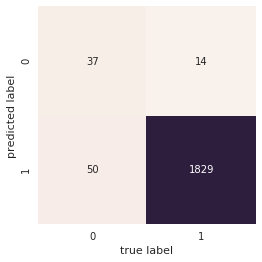

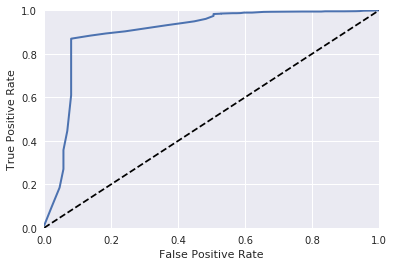

0.8985100504549677


In [8]:
evaluating(model_tree, ytest, ypred_tree, Xtest)

In [ ]:
#trabalhando com técnicas de imbalanced

In [10]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import cross_validate

tree = DecisionTreeClassifier(max_features='auto')
resampled_rf = BalancedBaggingClassifier(base_estimator=tree,
                                         n_estimators=100, random_state=0)
scores = cross_validate(resampled_rf,
                        Xtrain, ytrain, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.926862903945664, 0.9950539524064279)

             precision    recall  f1-score   support

          0       0.31      0.86      0.45        87
          1       0.99      0.91      0.95      1843

avg / total       0.96      0.91      0.93      1930

Valor de falso positivo:0.13793103448275862
Cálculo de índices de avaliação:
Precisão: 0.992883; Recall: 0.908302, F1: 0.948711
Precisão CV:


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.93298969 0.87113402 0.87113402 0.9015544  0.89119171 0.9119171
 0.89637306 0.93229167 0.90104167 0.88020833]
0.8989835668055483


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


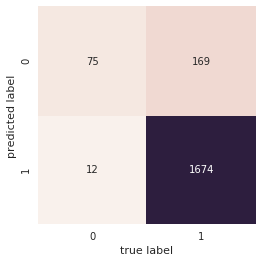

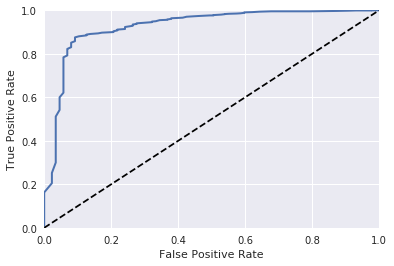

0.9270461079823625


In [11]:
ensemble = resampled_rf.fit(Xtrain, ytrain)

ypred_ensemble = ensemble.predict(Xtest)
print(classification_report(ytest, ypred_ensemble))

evaluating(ensemble, ytest, ypred_ensemble, Xtest)

{'n_estimators': 200}
0.9282470545421149
0.925220088494029
0.9949733656399478
             precision    recall  f1-score   support

          0       0.32      0.85      0.47        87
          1       0.99      0.92      0.95      1843

avg / total       0.96      0.91      0.93      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Valor de falso positivo:0.14942528735632185
Cálculo de índices de avaliação:
Precisão: 0.992357; Recall: 0.915898, F1: 0.952596
Precisão CV:
[0.94329897 0.86082474 0.89175258 0.9119171  0.89119171 0.9015544
 0.89119171 0.9375     0.90625    0.88541667]
0.9020897877606252


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


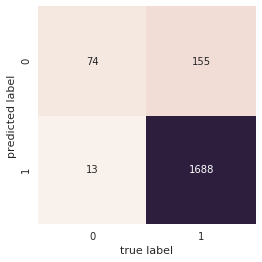

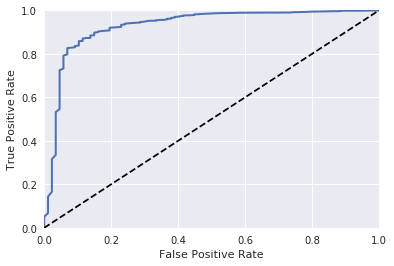

0.92816871542525


In [12]:
# Grid search with scoring based on decision_function
parameters = {'n_estimators': (10, 30, 100, 200)}

grid = GridSearchCV(BalancedBaggingClassifier(DecisionTreeClassifier(max_features='auto')),
             parameters,
             scoring="roc_auc")

grid.fit(Xtrain, ytrain)

print(grid.best_params_)
print(grid.best_score_)
ensemble = grid.best_estimator_

#tree = DecisionTreeClassifier(max_features='auto')
#resampled_rf = BalancedBaggingClassifier(base_estimator=tree, n_estimators=100, random_state=0)

scores = cross_validate(ensemble,
                        Xtrain, ytrain, cv=10, scoring=('roc_auc', 'average_precision'))

print(scores['test_roc_auc'].mean())
print(scores['test_average_precision'].mean())

ypred_ensemble = ensemble.predict(Xtest)
print(classification_report(ytest, ypred_ensemble))

evaluating(ensemble, ytest, ypred_ensemble, Xtest)

{'n_estimators': 200}
0.9187640114918161
             precision    recall  f1-score   support

          0       0.88      0.32      0.47        87
          1       0.97      1.00      0.98      1843

avg / total       0.96      0.97      0.96      1930

Valor de falso positivo:0.6781609195402298
Cálculo de índices de avaliação:
Precisão: 0.968915; Recall: 0.997830, F1: 0.983160
Precisão CV:


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.95876289 0.97938144 0.96391753 0.95854922 0.96373057 0.96373057
 0.95336788 0.97395833 0.96354167 0.94791667]
0.9626856760678738


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


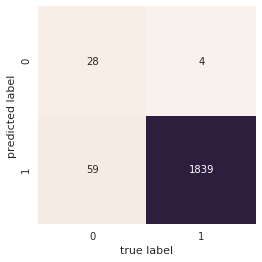

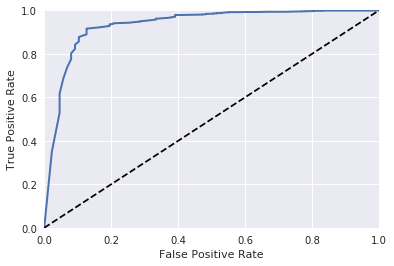

0.9321165515994037


(0.9234767493177646, 0.9942375069317352)

In [9]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report

# Grid search with scoring based on decision_function
parameters = {'n_estimators': (10, 30, 100, 200)}

grid = GridSearchCV(RandomForestClassifier(max_features='auto', class_weight='balanced'),
             parameters,
             scoring="roc_auc")

grid.fit(Xtrain, ytrain)

print(grid.best_params_)
print(grid.best_score_)
ensemble = grid.best_estimator_

scores = cross_validate(ensemble,
                        Xtrain, ytrain, cv=10, scoring=('roc_auc', 'average_precision'))

ypred_ensemble = ensemble.predict(Xtest)
print(classification_report(ytest, ypred_ensemble))

evaluating(ensemble, ytest, ypred_ensemble, Xtest)

scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [8]:
from imblearn.ensemble import BalanceCascade

RND_SEED = 0
ratio = 'auto'
estimator = RandomForestClassifier(random_state=RND_SEED)
bc = BalanceCascade(ratio=ratio, random_state=RND_SEED,
                    return_indices=False, estimator=estimator)
X_resampled, y_resampled = bc.fit_sample(Xtrain, ytrain)

In [9]:
print(X_resampled.shape)
print(y_resampled.shape)
print(X.shape)

(28, 524, 151)
(28, 524)
(7718, 151)


In [18]:
from sklearn.ensemble import AdaBoostClassifier

ens = BalanceCascade(classifer='adaboost')
X_train_res, y_train_res = ens.fit_sample(Xtrain, ytrain)

y_pred_proba = np.zeros(len(ytest))
for idx in range(len(y_train_res)):
    clf = AdaBoostClassifier()
    clf.fit(X_train_res[idx], y_train_res[idx])
    y_pred_proba += zip(*clf.predict_proba(Xtest))[0]
    
y_pred_proba = y_pred_proba/len(y_train_res)
ypred = (y_pred_proba > 0.5).astype(int)
#ypred = ypred.astype('str')


TypeError: 'zip' object is not subscriptable

In [ ]:
#FIM

In [ ]:
#https://amueller.github.io/COMS4995-s18/slides/aml-13-022818-resampling-imbalanced-data/#16

In [13]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(Xtrain, ytrain)

print(Xtrain.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

(5788, 151)
(524, 151)
[262 262]


In [17]:
from sklearn.linear_model import LogisticRegressionCV
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.model_selection import cross_validate

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegressionCV())
scores = cross_validate(undersample_pipe,
                        Xtrain, ytrain, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9033623704716165, 0.9935203930343187)

In [19]:
undersample_pipe_rf = make_imb_pipeline(RandomUnderSampler(),
                                        RandomForestClassifier())
scores = cross_validate(undersample_pipe_rf,
                        Xtrain, ytrain, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.908199693226523, 0.9935355217755678)

In [21]:
from sklearn.linear_model import LogisticRegression

scores = cross_validate(LogisticRegression(class_weight='balanced'),
                        Xtrain, ytrain, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.8927508232406416, 0.9915636423533091)

In [22]:
scores = cross_validate(RandomForestClassifier(n_estimators=100, class_weight='balanced'),
                        Xtrain, ytrain, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9145536993861842, 0.9932346792261978)

In [23]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
tree = DecisionTreeClassifier(max_features='auto')
resampled_rf = BalancedBaggingClassifier(base_estimator=tree,
                                         n_estimators=100, random_state=0)
scores = cross_validate(resampled_rf,
                        Xtrain, ytrain, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.926862903945664, 0.9950539524064279)

             precision    recall  f1-score   support

          0       0.31      0.86      0.45        87
          1       0.99      0.91      0.95      1843

avg / total       0.96      0.91      0.93      1930

Valor de falso positivo:0.13793103448275862
Cálculo de índices de avaliação:
Precisão: 0.992883; Recall: 0.908302, F1: 0.948711
Precisão CV:


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.93298969 0.87113402 0.87113402 0.9015544  0.89119171 0.9119171
 0.89637306 0.93229167 0.90104167 0.88020833]
0.8989835668055483


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


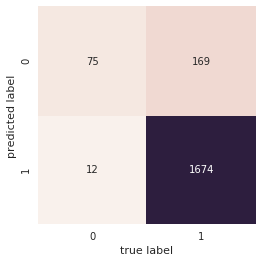

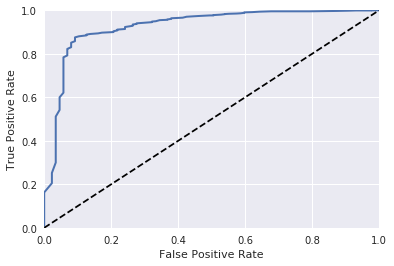

0.9270461079823625


In [32]:
#AQUIIIIIIIIII
#meus testes
ensemble = resampled_rf.fit(Xtrain, ytrain)

ypred_ensemble = ensemble.predict(Xtest)
print(classification_report(ytest, ypred_ensemble))

evaluating(ensemble, ytest, ypred_ensemble, Xtest)

In [ ]:
#FIM DE TESTE

In [24]:
from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours(n_neighbors=5)
X_train_enn, y_train_enn = enn.fit_sample(Xtrain, ytrain)
enn_mode = EditedNearestNeighbours(kind_sel="mode", n_neighbors=5)
X_train_enn_mode, y_train_enn_mode = enn_mode.fit_sample(Xtrain, ytrain)

In [26]:
enn_pipe = make_imb_pipeline(EditedNearestNeighbours(n_neighbors=5),
                             LogisticRegression())
scores = cross_val_score(enn_pipe, Xtrain, ytrain, cv=10, scoring='roc_auc')
np.mean(scores)



0.9080742611665837

In [28]:
enn_pipe_rf = make_imb_pipeline(EditedNearestNeighbours(n_neighbors= 5),
                                  RandomForestClassifier(n_estimators=100))
scores = cross_val_score(enn_pipe_rf, Xtrain, ytrain, cv=10, scoring='roc_auc')
np.mean(scores)

0.9200925147540447

In [30]:
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour()
X_train_cnn, y_train_cnn = cnn.fit_sample(Xtrain, ytrain)
print(X_train_cnn.shape)
print(np.bincount(y_train_cnn))

(904, 151)
[262 642]


In [31]:
cnn_pipe = make_imb_pipeline(CondensedNearestNeighbour(), LogisticRegression())
scores = cross_val_score(cnn_pipe, Xtrain, ytrain, cv=10, scoring='roc_auc')
np.mean(scores)

KeyboardInterrupt: 

In [ ]:
cnn_pipe = make_imb_pipeline(CondensedNearestNeighbour(),
                              RandomForestClassifier(n_estimators=100))
scores = cross_val_score(cnn_pipe, Xtrain, ytrain, cv=10, scoring='roc_auc')
np.mean(scores)

In [ ]:
#TESTE ENSEMBLE BALANCED

In [14]:
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.ensemble import BalancedBaggingClassifier 

#X, y = make_classification(n_classes=2, class_sep=2,
#weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
#n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)

print('Original dataset shape {}'.format(Counter(y)))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
bbc = BalancedBaggingClassifier(random_state=42)
bbc.fit(X_train, y_train) 

y_pred = bbc.predict(X_test)
print(confusion_matrix(y_test, y_pred))

Original dataset shape Counter({1: 7369, 0: 349})
[[  68   10]
 [ 234 1618]]
